# **Homework 1 - Text Mining**

## Group Members:
1. **Tarang Kadyan**  
   <tarang.kadyan@bse.eu>

2. **Oriol Gelabert**  
   <oriol.gelabert@bse.eu>

3. **Enzo Infantes**  
   <enzo.infantes@bse.eu>

<img src='https://upload.wikimedia.org/wikipedia/commons/4/41/BSE_primary_logo_color.jpg' width=300 />

# **0. Libraries**

In [19]:
import os
import time

import pandas as pd
import numpy as np
import re
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

from packages.selenium_setup import *
from packages.scraper import BookingScraper
from packages.dataloading import DataCollection
from packages.processing import TextPreprocessor

# **1. Scraping**
This contains past preferences such as passwords, cookie acceptance etc.

Open **Booking.com** website to start our search. \
Note: In this step, we are using the functions from `selenium_setup.py` file.

In [ ]:
dfolder= os.getcwd()
geko_path = os.path.join(dfolder, 'geckodriver.exe')
link='https://www.booking.com/index.es.html'

browser=start_up(dfolder=dfolder,link=link,geko_path=geko_path)

## **1.1 Booking Search**
In this section, we are using the `BookingScraper` class from `scraper.py`. Inside it, the following steps are performed:

- Reject cookies avoiding possible interference when scrapping.
- Google Log-in Pop-Up is inside an Iframe object. It must be closed.
- Define and search for our destination (city).
- Specify the month and the exact date (month and day).
- Click the search button.
- Genius pop-up might appear. It must be closed.
- **Important Step**: Now, we want to extract information from all hotels in Barcelona. The issue is that Booking initially displays only 25 hotels, and as you scroll down, it loads up to 75 before requiring a click on the 'Load More' button. To handle this, we create a function that scrolls to the bottom of the page (`scroll_and_click`), searches for this clickable button, and clicks it. This process runs in a while loop until the 'Load More' button is no longer available, indicating that all possible hotels have been displayed.

We are selecting the dates of the event we want to track, in our case MWC. This event is hosted between 3-6 March, so our initial serach will be on the week of 01 to 08 March.

In [ ]:
scraper = BookingScraper(browser)
scraper.run_pipeline(place="Barcelona", 
                     target_month="marzo", 
                     target_year="2025",
                     from_date="03-01", 
                     to_date="03-08")

## **1.2 Data Loading**
Now we have all the hotels loaded we will extract some information from them. After a quick inspection we identify several elements that could be usefull when analyzing an hotel:

* Hotel name : Can be used as an identifier
* Price : We can get the price of the stay for each hotel
* Rating: The feedback given by consumers of booking for each hotel
* Stars: We can also retrieve the number of stars of an hotel
* Distance to the center: This could indicate us if only central hotels are affected by an increase of prices.
* Neigbourhood: Maybe only certain neighbourhoods are affected by the presence of an event.
* Link: The link from booking for each hotel. 

**Note**: To extract all of these values we are using the function `get_hotel_information` from `dataloading.py` file.

There are some mismatches in the stars or ratings due to the same field format. Additionally, there are hotels without information about their rating or stars, and these will be considered as null values. To avoid this mismatch, we will access the container containing all properties for each hotel. Furthermore, we will extract the elements directly, not in their Selenium object format as done previously, but in a processed way. We use **RegEx** to extract the number of stars directly as an integer and also isolate the hotel Booking rating as a number. 

Finally, we use `requests` and `BeautifulSoup` to extract the description of each hotel, on this steps we also are using `ThreadPoolExecutor` to save time in this process. All these steps are available in the `dataloading.py` file.

In [4]:
data_collector = DataCollection(browser)
data = data_collector.get_all_hotel_data()

In [7]:
data.to_csv("Barcelona_MWC.csv", index=True, encoding='utf-8')
browser.close()

**Note**: This process must be executed four times according to the requirements. For each city (a total of two), we need to extract information about hotels during two different time periods (Part 3).

- **Milan**: We chose Milan as the second city to extract information because it has a similar population to Barcelona. Additionally, Milan is close to Spain and is a common destination for tourists too.

In [21]:
browser=start_up(dfolder=dfolder,link=link,geko_path=geko_path)
scraper = BookingScraper(browser)
scraper.run_pipeline(place="Milan", 
                     target_month="marzo", 
                     target_year="2025",
                     from_date="03-01", 
                     to_date="03-08")
data_collector = DataCollection(browser)
data = data_collector.get_all_hotel_data()
data.to_csv("Milan_MWC.csv", index=True, encoding='utf-8')
browser.close()

- **Data for August**: According to the instructions, we need to extract information about hotels from at least two separate weeks starting from our first date for each city.

In [ ]:
# Barcelona
browser=start_up(dfolder=dfolder,link=link,geko_path=geko_path)
scraper = BookingScraper(browser)
scraper.run_pipeline(place="Barcelona", 
                     target_month="agosto", 
                     target_year="2025",
                     from_date="08-01", 
                     to_date="08-08")
data_collector = DataCollection(browser)
data = data_collector.get_all_hotel_data()
data.to_csv("Barcelona_Control.csv", index=True, encoding='utf-8')
browser.close()

In [ ]:
# Milan
browser=start_up(dfolder=dfolder,link=link,geko_path=geko_path)
scraper = BookingScraper(browser)
scraper.run_pipeline(place="Milan", 
                     target_month="agosto", 
                     target_year="2025",
                     from_date="08-01", 
                     to_date="08-08")
data_collector = DataCollection(browser)
data = data_collector.get_all_hotel_data()
data.to_csv("Milan_Control.csv", index=True, encoding='utf-8')
browser.close()

# **2. Text analysis**

After extracting all the data about the hotels for our two cities, including their descriptions, we perform some pre-processing steps on our data.

## **2.1. Pre-process: stop words and stemming**

In [91]:
df_MWC_BCN = pd.read_csv("Barcelona_MWC.csv", index_col=0)
df_MWC_Milan = pd.read_csv("Milan_MWC.csv", index_col=0)

df_Control_Barcelona = pd.read_csv("Barcelona_Control.csv", index_col=0)
df_Control_Milan = pd.read_csv("Milan_Control.csv", index_col=0)

dfs = [df_MWC_BCN, df_MWC_Milan, df_Control_Barcelona, df_Control_Milan]

In [93]:
# Only to standardize all column names (not necessary in some cases
for df in dfs:
    df.rename(columns={
        "Hotel Names": "name",
        "Rating": "rating",
        "Stars": "stars",
        "Location": "location",
        "Center Distance": "distance",
        "Price": "price",
        "Description": "description"}, inplace=True)

In [78]:
# Define the preprocessing pipeline
extra_words = {"hotel", "habitacion", "huespedes", "ubicacion"}
preprocessor = TextPreprocessor(extra_stopwords=extra_words)

for df in dfs:
    df["processed_description"] = df["description"].apply(preprocessor.preprocess_text)

df_MWC_BCN[['description', 'processed_description']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Enzo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,description,processed_description
0,Chic&basic Habana Hoose es un alojamiento con ...,chicbasic haban hoos aloj ubic excelent barcel...
1,"Sonder Los Arcos está en Barcelona, a 2 km de ...",sond arcos barcelon km platj sant miquel km pl...
2,El BARCELONA GOTIC Guesthouse ocupa un edifici...,barcelon gotic guesthous ocup edifici sigl xix...
3,La Residencia Campus del Mar está muy bien ubi...,resident campus mar bien ubic barri barcelonet...
4,Este moderno hotel cuenta con 250 amplias y co...,modern cuent ampli complet equip habit snackb ...


## **2.2. Wordclouds**

The preprocessed wordclouds show fewer irrelevant words, highlighting more meaningful terms like "beach," "modern," and "comfortable." Stemming reduces redundancy (e.g., "ubicación" → "ubicado"), improving clarity. This enhances interpretation and prepares the text for better analysis.

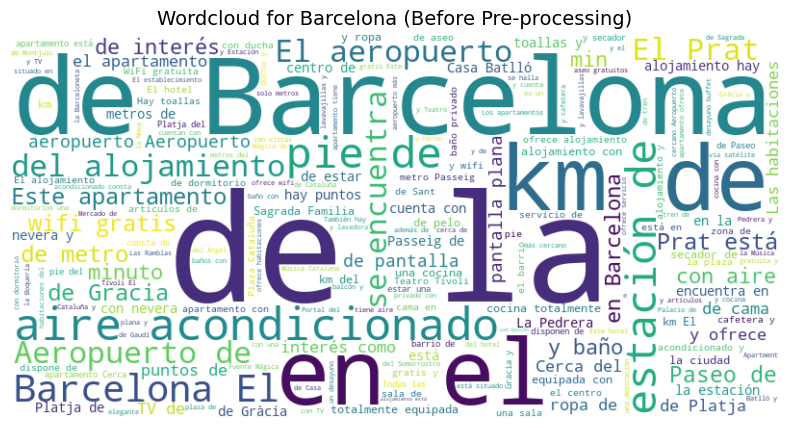

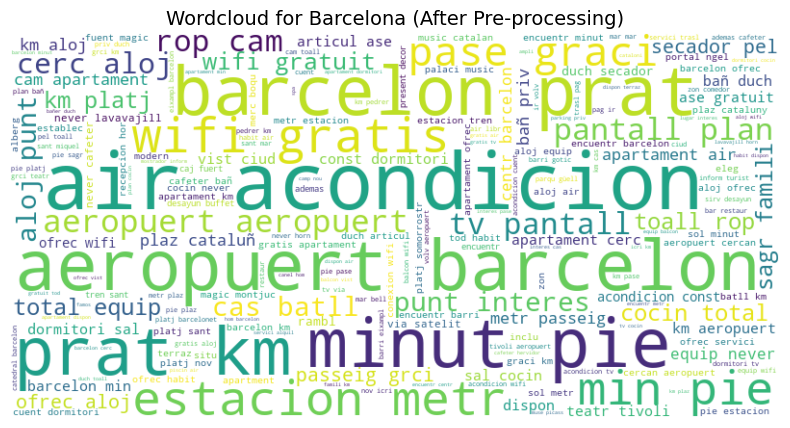

In [79]:
preprocessor.generate_wordcloud(df_MWC_BCN["description"], "Wordcloud for Barcelona (Before Pre-processing)")
preprocessor.generate_wordcloud(df_MWC_BCN["processed_description"], "Wordcloud for Barcelona (After Pre-processing)")

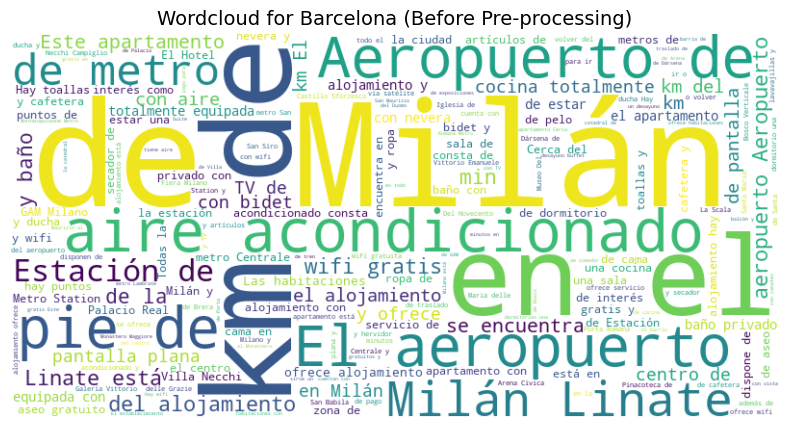

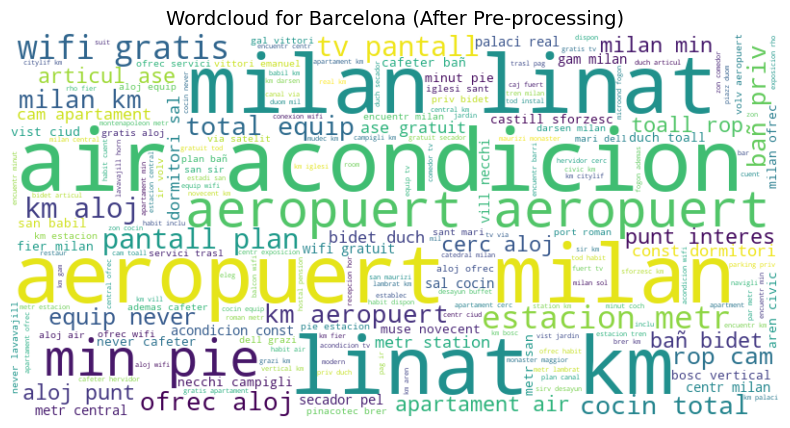

In [80]:
preprocessor.generate_wordcloud(df_MWC_Milan["description"], "Wordcloud for Barcelona (Before Pre-processing)")
preprocessor.generate_wordcloud(df_MWC_Milan["processed_description"], "Wordcloud for Barcelona (After Pre-processing)")

**Note**: Looking at some of the relevant words, we create some dummies to identify if an hotel description contains certain words or not. Finally, our data will have few more columns for these relevant words, they will be dummies columns if one specifit hotel has, or not, that characteristic.

In [81]:
def contains_keyword(description, keywords):
    '''
    Check if a description contains any of the keywords
    Lowercases the description and keywords before checking  
    '''
    words = description.lower().split()
    return 1 if any(keyword.lower() in words for keyword in keywords) else 0

In [82]:
# Define keyword categories
keyword_dict = {
    "Air": ['air', 'acondicion'],
    "Gratis": ['gratis', 'gratuit', 'free'],
    "Cocina": ['cocin', ''],
    "Desayuno": ['desayuno'],
    "Piscina": ['piscina', 'pool']
}

# Apply the function in each dataframe
for df in dfs:
    for column, keywords in keyword_dict.items():
        source_col = 'description' if column in ['Desayuno', 'Piscina'] else 'processed_description'
        df[column] = df[source_col].apply(lambda x: contains_keyword(x, keywords))

In [83]:
df_MWC_BCN.head(3)

,name,rating,stars,location,distance,price,description,processed_description,Air,Gratis,Cocina,Desayuno,Piscina
0,chic&basic Habana Hoose,"8,5",3.0,Ciutat Vella,0.9,2.773,Chic&basic Habana Hoose es un alojamiento con ...,chicbasic haban hoos aloj ubic excelent barcel...,1,1,0,1,0
1,Sonder Los Arcos,"8,2",NaN,Ciutat Vella,1.0,3.152,"Sonder Los Arcos está en Barcelona, a 2 km de ...",sond arcos barcelon km platj sant miquel km pl...,1,1,0,0,0
2,BARCELONA GOTIC Guesthouse,"7,7",1.0,Ciutat Vella,1.0,839.000,El BARCELONA GOTIC Guesthouse ocupa un edifici...,barcelon gotic guesthous ocup edifici sigl xix...,0,1,0,0,0


# **3. DiD**

We will apply Differences-in-differences methodology in DiD regressions with the dataset we have collected.

For the DiD Regression we need to study the same hotels in both cases so we merge both periods datasets with an inner join and filter on both dataframes only the hotels that accepted the join.

In [84]:
merged_df = df_MWC_BCN.merge(df_Control_Barcelona, on = 'name', how = 'inner')
common_bcn=merged_df['name']
df_MWC_BCN=df_MWC_BCN[df_MWC_BCN['name'].isin(common_bcn)]
df_Control_Barcelona=df_Control_Barcelona[df_Control_Barcelona['name'].isin(common_bcn)]

merged_df = df_MWC_Milan.merge(df_Control_Milan, on = 'name', how = 'inner')
common_milan=merged_df['name']
df_MWC_Milan=df_MWC_Milan[df_MWC_Milan['name'].isin(common_milan)]
df_Control_Milan=df_Control_Milan[df_Control_Milan['name'].isin(common_milan)]

Now we assign a Treated variable to each data frame and a Period one to each one.

In [ ]:
df_MWC_BCN["Treated"] = 1
df_Control_Barcelona["Treated"] = 1 
df_MWC_Milan["Treated"] = 0
df_Control_Milan["Treated"] = 0

df_MWC_BCN["Period"] = 1
df_Control_Barcelona["Period"] = 0 
df_MWC_Milan["Period"] = 1
df_Control_Milan["Period"] = 0

We concatenate both dataframes in a big one, to do the DiD regression on it and create a variable multiplying the previously created dummies:

In [86]:
df = pd.concat([df_MWC_BCN, df_Control_Barcelona, df_MWC_Milan, df_Control_Milan], ignore_index=True)

df["DiD"] = df["Treated"] * df["Period"]

**DiD Regression**

The regression equation is as follows:

$$
\text{price}_{itp} = \beta_0 + \beta_1 (\text{treated}_t) + \beta_2 (\text{period}_p) + \beta_3 (\text{treated}_t \times \text{period}_p) +\mathbf{C}_{i}\mathbf{B}_{i}+ \epsilon_{itp}
$$

In this equation is the dependant variable, $\beta_0$ the intercept, $\beta_1$ indicates the price difference between cities $\beta_2$ capatures the price difference between periods and $\beta_3$ is the Did term that measures the effect of the event on Barcelona. $ \mathbf{C}_{i} $ is the vector of other control variables  and $ \mathbf{B}_{i} $ the corresponding coefficients of this additional control variables. $\epsilon_{ict}$ refers to an error term. The indices in the equation correspond to: *i* for each observed hotel, *t* indicates treated city with 1 (Barcelona) and 0 to the control (Milan) and *p* for period (1 during MWC dates, 0 otherwise).

In [87]:
df['price']=np.log(df['price'])
df["rating"] = df["rating"].str.replace(",", ".").astype(float)

df_clean=df.dropna(subset=['rating','stars'])

df.head(3)

,name,rating,stars,location,distance,price,description,processed_description,Air,Gratis,Cocina,Desayuno,Piscina,Treated,Period,DiD
0,chic&basic Habana Hoose,8.5,3.0,Ciutat Vella,0.9,1.019930,Chic&basic Habana Hoose es un alojamiento con ...,chicbasic haban hoos aloj ubic excelent barcel...,1,1,0,1,0,1,1,1
1,Sonder Los Arcos,8.2,NaN,Ciutat Vella,1.0,1.148037,"Sonder Los Arcos está en Barcelona, a 2 km de ...",sond arcos barcelon km platj sant miquel km pl...,1,1,0,0,0,1,1,1
2,BARCELONA GOTIC Guesthouse,7.7,1.0,Ciutat Vella,1.0,6.732211,El BARCELONA GOTIC Guesthouse ocupa un edifici...,barcelon gotic guesthous ocup edifici sigl xix...,0,1,0,0,0,1,1,1


## **3.1. DiD using only variables from hotels**

We first will run a DiD regression using simply the information extracted from the hotels and detailing the controls that we will use apart from the DiD variables to construct it.

We can add as the controls in thei preliminary regression:
- Hotel Rating: a numerical value that goes from 0.0 to 10.0.
- Stars classification: An integer value that can be between 1 and 5.

Then a regression is ran using OLS and the following results are obtained.

In [88]:
modela = smf.ols("price ~ Treated + Period + DiD + rating + stars + distance", data=df_clean).fit(cov_type='HC1')

print(modela.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     20.53
Date:                Wed, 05 Feb 2025   Prob (F-statistic):           3.56e-23
Time:                        19:35:23   Log-Likelihood:                -3055.4
No. Observations:                1449   AIC:                             6125.
Df Residuals:                    1442   BIC:                             6162.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3428      0.936      7.847      0.0

C:\Users\Enzo\AppData\Local\Temp\ipykernel_6832\182329849.py:13: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x=coefficients.index, y=coefficients.values, join=False, capsize=0.2)


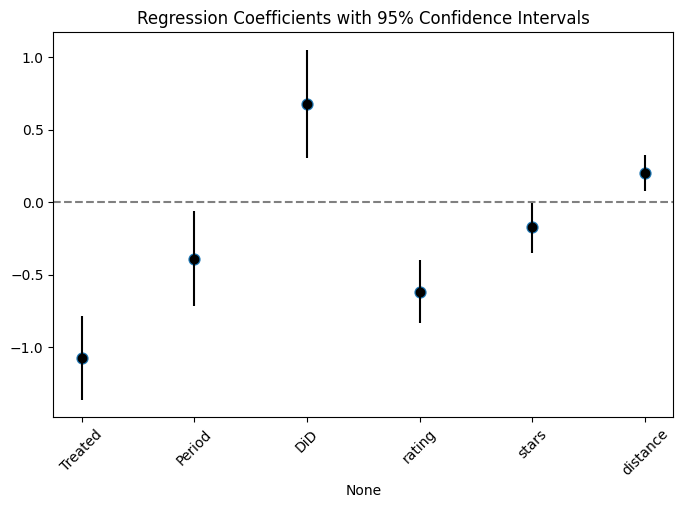

In [89]:
# Extract coefficients and confidence intervals
coefficients = modela.params
conf_int = modela.conf_int()
conf_int.columns = ['low', 'high']

# Select only relevant variables
variables_of_interest = ["Treated", "Period", "DiD", "rating", "stars","distance"]
coefficients = coefficients[variables_of_interest]
conf_int = conf_int.loc[variables_of_interest]

# Plot
plt.figure(figsize=(8,5))
sns.pointplot(x=coefficients.index, y=coefficients.values, join=False, capsize=0.2)
plt.errorbar(coefficients.index, coefficients.values, 
             yerr=[coefficients - conf_int['low'], conf_int['high'] - coefficients], 
             fmt='o', color='black')

plt.axhline(0, linestyle="--", color="gray")
plt.title("Regression Coefficients with 95% Confidence Intervals")
plt.xticks(rotation=45)
plt.show()

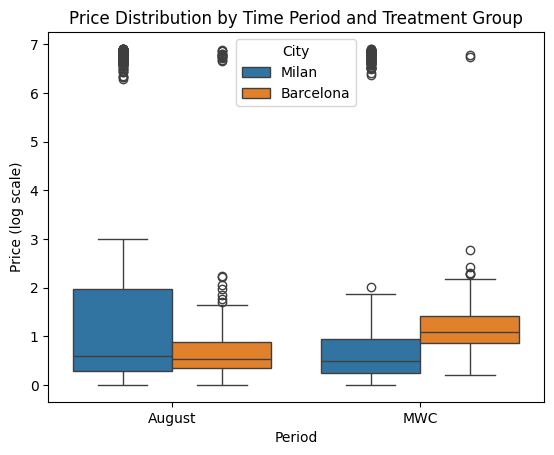

In [90]:
sns.boxplot(x='Period', y='price', hue='Treated', data=df_clean)

plt.title("Price Distribution by Time Period and Treatment Group")
plt.xlabel("Period")
plt.ylabel("Price (log scale)")
plt.xticks([0, 1], ['August', 'MWC']) 
handles, labels = plt.gca().get_legend_handles_labels()  
plt.legend(handles=handles, labels=['Milan', 'Barcelona'], title="City")
plt.show()

## **3.2. DiD using text features from the description**

In [97]:
modelb = smf.ols("price ~ Treated + Period + DiD + rating + stars + distance + Desayuno + Air + Piscina + Cocina + Gratis", data=df_clean).fit(cov_type='HC1')

print(modelb.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     11.42
Date:                Wed, 05 Feb 2025   Prob (F-statistic):           1.23e-20
Time:                        19:38:50   Log-Likelihood:                -3052.7
No. Observations:                1449   AIC:                             6129.
Df Residuals:                    1437   BIC:                             6193.
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3308      0.950      7.713      0.0

C:\Users\Enzo\AppData\Local\Temp\ipykernel_6832\3218548229.py:13: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x=coefficients.index, y=coefficients.values, join=False, capsize=0.2)


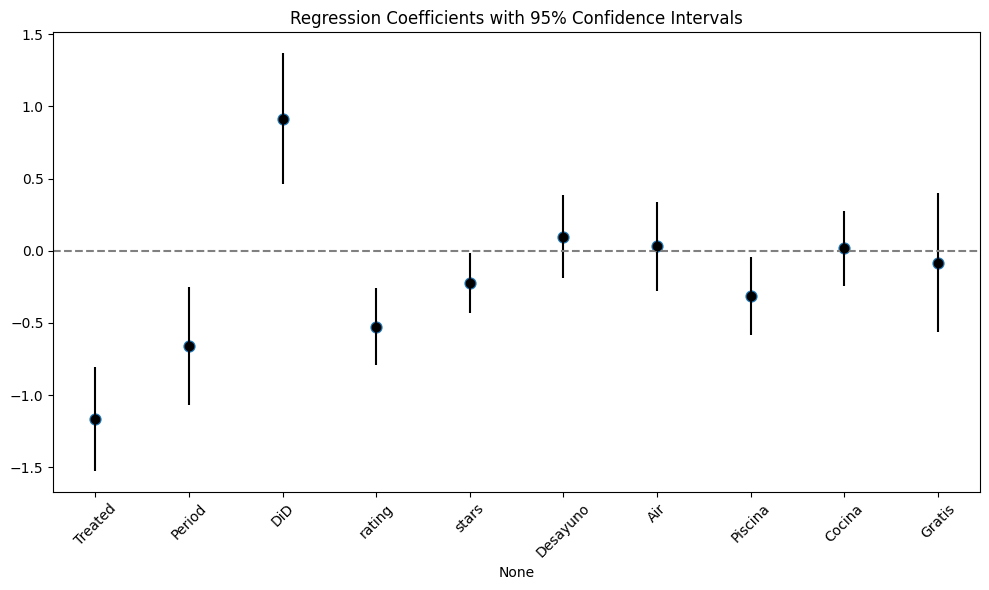

In [74]:
# Extract coefficients and confidence intervals
coefficients = modelb.params
conf_int = modelb.conf_int()
conf_int.columns = ['low', 'high']

# Select only relevant variables
variables_of_interest = ["Treated", "Period", "DiD", "rating", "stars", "Desayuno", "Air", "Piscina", "Cocina", "Gratis"]
coefficients = coefficients[variables_of_interest]
conf_int = conf_int.loc[variables_of_interest]

# Plot
plt.figure(figsize=(10,6))
sns.pointplot(x=coefficients.index, y=coefficients.values, join=False, capsize=0.2)
plt.errorbar(coefficients.index, coefficients.values, 
             yerr=[coefficients - conf_int['low'], conf_int['high'] - coefficients], 
             fmt='o', color='black')

plt.axhline(0, linestyle="--", color="gray")
plt.title("Regression Coefficients with 95% Confidence Intervals")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **3.3. Treatment effect by quality**
We add some words that are considered as Luxury indicators into a list and identify if they are present at each hotel description:

In [100]:
df_clean['Luxury']=df_clean['description'].apply(lambda x: contains_keyword(x,
['spa','lujo','exclusivo','gourmet','sauna','elegante','boutique','vistas','azotea']))

In [101]:
modelb = smf.ols("price ~ Treated + Period + DiD + stars + Luxury", data=df_clean).fit(cov_type='HC1')

print(modelb.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     19.60
Date:                Wed, 05 Feb 2025   Prob (F-statistic):           6.25e-19
Time:                        19:40:30   Log-Likelihood:                -3102.8
No. Observations:                1449   AIC:                             6218.
Df Residuals:                    1443   BIC:                             6249.
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3158      0.340      9.750      0.0